Name: Vidhi Khandelwal

GW ID: G30891152

In [ ]:
#@title Setup Installation
!pip install datasets
!pip install rouge-score
!pip install -q -U "tensorflow-text==2.8.*"
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q -U tensorflow-text tensorflow tensorflow==2.15.0
print("NOTE: You should restart the runtime session after this completes.")

# Ignore the error:
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
 

In [ ]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################

import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from typing import Dict, Optional, Sequence
import tensorflow as tf
from gc import callbacks
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from google.colab import drive # For saving vocabulary and model checkpoints.
from tensorflow.python.ops.numpy_ops import np_config
from IPython.display import display, HTML
from rouge_score import rouge_scorer
from datasets import load_dataset

In [ ]:
#@title Set up the vocabulary and checkpoint paths on gDrive

drive.mount('/content/gdrive', force_remount=True)
checkpoint_filepath = F'/content/gdrive/My Drive/ml_course/hw5_tuned/models/summarizer/checkpoints'
vocabulary_filepath =  F'/content/gdrive/My Drive/ml_course/hw5_tuned/models/summarizer/vocabulary'
vocabulary_file = os.path.join(vocabulary_filepath, 'vocabulary')

# For saving the vocabulary
if not os.path.exists(vocabulary_filepath) :
  print('Creating vocabulary file path %s' %vocabulary_filepath)
  os.makedirs(vocabulary_filepath)

# For saving the model weights
if not os.path.exists(checkpoint_filepath) :
  print('Creating checkpoint directory %s' %checkpoint_filepath)
  os.makedirs(checkpoint_filepath)

Mounted at /content/gdrive


In [ ]:
# @title Load and configure the SummScreen dataset.

dataset = load_dataset("YuanPJ/summ_screen", 'all')


def to_dataset(df: pd.DataFrame):
  df['transcript'] = [trans[0] for trans in df['Transcript']]
  df['recap'] = [recap[0] for recap in df['Recap']]
  return tf.data.Dataset.from_tensor_slices((df['transcript'].values, df['recap'].values))

train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])


ds_train = to_dataset(train_df)
ds_val = to_dataset(validation_df)
ds_test = to_dataset(test_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


summ_screen.py:   0%|          | 0.00/5.48k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/36.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22588 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2130 [00:00<?, ? examples/s]

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
VOCABULARY_LENGTH = 8000

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = VOCABULARY_LENGTH,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")


In [ ]:
def to_lowercase(transcript, recap = ""):
  return tf.strings.lower(transcript), tf.strings.lower(recap)


def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)


def get_transcript(transcript, recap):
  return transcript

In [ ]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    ds_train.batch(1000).map(to_lowercase).map(get_transcript).prefetch(2),
    **bert_vocab_args
)

CPU times: user 23.6 s, sys: 144 ms, total: 23.7 s
Wall time: 22.1 s


In [ ]:
# Inspect the tokens of your vocabulary at different locations:
print(en_vocab[:30])
print(en_vocab[100:110])
print(en_vocab[1000:1010])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':']
['do', 'here', 'oh', 'not', 'was', 'hey', 'don', 'previously', 'right', 'at']
['hit', 'marty', 'normal', 'park', 'prison', 'rather', 'teleplay', 'upset', '##ish', '##ley']
['##q', '##{', '##|', '##}', '##~', '##æ', '##‐', '##•', '##♪', '##�']


In [ ]:
ds_train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
#@title Save the vocabulary path to gDrive
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

write_vocab_file(vocabulary_file, en_vocab)
!cat "$vocabulary_file"
print('Saved the vocabulary to %s.' %vocabulary_file)

[PAD]
[UNK]
[START]
[END]
!
"
#
$
%
&
'
(
)
*
+
,
-
.
/
0
1
2
3
4
5
6
7
8
9
:
;
?
@
[
\
]
_
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
{
|
}
~
æ
‐
•
♪
�
you
the
to
and
it
on
that
of
is
in
me
this
what
##s
my
we
for
are
so
have
your
re
be
know
can
with
just
all
do
here
oh
not
was
hey
don
previously
right
at
there
up
no
she
get
but
he
out
want
her
about
##ing
if
how
going
okay
one
as
like
now
did
##ed
go
will
from
ve
back
good
come
well
got
see
ll
by
think
time
him
his
sighs
they
scene
tell
when
look
need
brooke
##d
gonna
really
let
or
been
where
who
door
love
please
would
##y
could
some
something
doing
why
an
hope
jack
night
thank
our
yeah
make
say
were
little
over
sorry
has
ridge
nick
way
didn
us
god
##e
down
mean
take
##er
day
hi
had
then
am
home
##ly
##t
baby
call
man
off
music
much
carly
##a
help
uh
any
because
into
michael
morning
should
more
never
##n
again
everything
give
still
sure
them
keep
last
believe
find
house
phone
room
steffy
wait
thing
anything
katie
life
too
ve

In [ ]:
#@title Load the vocabulary path from gDrive
en_tokenizer = text.BertTokenizer(vocabulary_file, **bert_tokenizer_params)

In [ ]:


for transcript_example, recap_example in ds_train.batch(256).map(to_lowercase):
  transcript_tokens = en_tokenizer.tokenize(transcript_example)
  lengths = transcript_tokens.row_lengths()
  break



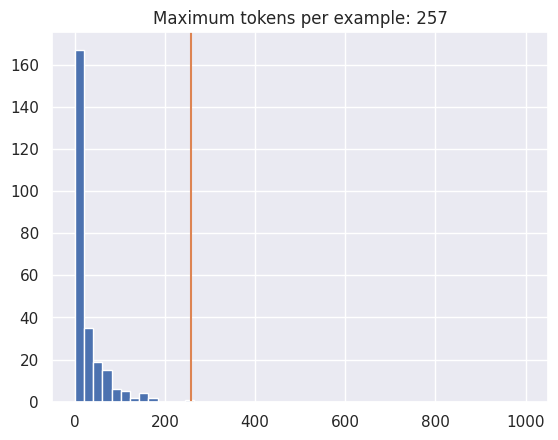

In [ ]:


plt.hist(lengths, np.linspace(0, 1000, 50))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim(), )
plt.title(f'Maximum tokens per example: {max_length}');

In [ ]:
MAX_TOKENS_TRANSCRIPT = 256
MAX_TOKENS_RECAP = 64

In [ ]:


def prepare_batch(transcript, recap):

    transcript_tokens = en_tokenizer.tokenize(transcript)

    transcript_tokens = transcript_tokens.merge_dims(-2,-1)

    transcript_tokens = transcript_tokens[:, :MAX_TOKENS_TRANSCRIPT]    # Trim to MAX_TOKENS.
    transcript_tokens = add_start_end(transcript_tokens)

    transcript_tokens = transcript_tokens.to_tensor()  # Convert to 0-padded dense Tensor

    recap_tokens = en_tokenizer.tokenize(recap)
    recap_tokens = recap_tokens.merge_dims(-2,-1)

    recap_tokens = recap_tokens[:, :(MAX_TOKENS_RECAP+1)]
    recap_tokens = add_start_end(recap_tokens)
    recap_inputs = recap_tokens[:, :-1].to_tensor()  # Drop the [END] tokens
    recap_labels = recap_tokens[:, 1:].to_tensor()   # Drop the [START] tokens

    return (transcript_tokens, recap_inputs), recap_labels


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(ds_train)
val_batches = make_batches(ds_val)

In [ ]:
#@title View an example of the input training data.
for (transcript_tokens, recap_inputs), recap_labels in ds_train.batch(1024).map(prepare_batch).take(1):
  print(transcript_tokens)
  print(recap_inputs)
  print(recap_labels)


tf.Tensor(
[[  2  11 685 ...   0   0   0]
 [  2  11  39 ...   0   0   0]
 [  2  11  39 ...   0   0   0]
 ...
 [  2  73  49 ...   0   0   0]
 [  2  73  49 ...   0   0   0]
 [  2  73  49 ...   0   0   0]], shape=(1024, 258), dtype=int64)
tf.Tensor(
[[   2  685 2730 ...   37 2004   74]
 [   2  685   10 ... 2330  343  877]
 [   2  685   10 ... 1256 2088   97]
 ...
 [   2  479  314 ...  886  134   73]
 [   2  479  314 ...  886  134   73]
 [   2  479  314 ...  886  134   73]], shape=(1024, 66), dtype=int64)
tf.Tensor(
[[ 685 2730   85 ... 2004   74    3]
 [ 685   10   55 ...  343  877    3]
 [ 685   10   55 ... 2088   97    3]
 ...
 [ 479  314   73 ...  134   73    3]
 [ 479  314   73 ...  134   73    3]
 [ 479  314   73 ...  134   73    3]], shape=(1024, 66), dtype=int64)


In [ ]:
for  (transcript_tokens, recap_inputs), recap_labels in train_batches.take(1):
  break

print(transcript_tokens.shape)
print(recap_inputs.shape)
print(recap_labels.shape)

(64, 255)
(64, 66)
(64, 66)


In [ ]:
print(recap_inputs[0][:])
print(recap_labels[0][:])

tf.Tensor(
[   2  539   75  175  478  814   75  149 1907  119  111   17  814 2136
  156   74  282  127  122  171  104  316  143  103  504  242   17  437
   37  259 3050  109 2346  793   10   55  311   75  331   74   95  122
  814  104  125   17  116  331   74   95   84  304   17  539 1717  156
  890   10   55  354  379 1478  219   73 1513   17], shape=(66,), dtype=int64)
tf.Tensor(
[ 539   75  175  478  814   75  149 1907  119  111   17  814 2136  156
   74  282  127  122  171  104  316  143  103  504  242   17  437   37
  259 3050  109 2346  793   10   55  311   75  331   74   95  122  814
  104  125   17  116  331   74   95   84  304   17  539 1717  156  890
   10   55  354  379 1478  219   73 1513   17    3], shape=(66,), dtype=int64)


In [ ]:
num_layers = 5
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.2

In [ ]:
MAX_TOKENS_TRANSCRIPT = 256
MAX_TOKENS_RECAP = 64
MAX_VOCABULARY = 8000  # Adjust as needed for your dataset

# Positional Encoding function
def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)

# Positional Embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

# Attention and FeedForward Layers
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Encoder Layers
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x

# Decoder Layers
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.last_attn_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)  # Shape `(batch_size, target_seq_len, d_model)`
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x

# Transformer Model
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)  # Shape `(batch_size, context_len, d_model)`
        x = self.decoder(x, context)  # Shape `(batch_size, target_len, d_model)`
        logits = self.final_layer(x)  # Shape `(batch_size, target_len, target_vocab_size)`
        return logits

# Custom learning rate schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {'d_model': self.d_model, 'warmup_steps': self.warmup_steps}

# Masked loss and accuracy
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    return tf.reduce_sum(tf.cast(match, tf.float32)) / tf.reduce_sum(tf.cast(mask, tf.float32))

# Example model instantiation
input_vocab_size = MAX_VOCABULARY
target_vocab_size = MAX_VOCABULARY  # Adjust accordingly
model = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size)

# Compile model with optimizer and loss function
learning_rate = CustomSchedule(d_model=d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_masked_accuracy', # Save when the validation masekd accuracy improves
    mode='max',
    save_best_only=True)

Epoch 1/100
353/353 [==============================] - 1272s 4s/step - loss: 7.8476 - masked_accuracy: 0.0381 - val_loss: 6.4963 - val_masked_accuracy: 0.0560
Epoch 2/100
353/353 [==============================] - 1274s 4s/step - loss: 5.9260 - masked_accuracy: 0.1051 - val_loss: 5.2391 - val_masked_accuracy: 0.1561
Epoch 3/100
353/353 [==============================] - 1289s 4s/step - loss: 4.9001 - masked_accuracy: 0.1816 - val_loss: 4.5735 - val_masked_accuracy: 0.2079
Epoch 4/100
353/353 [==============================] - 1255s 4s/step - loss: 4.4378 - masked_accuracy: 0.2181 - val_loss: 4.2318 - val_masked_accuracy: 0.2366
Epoch 5/100
353/353 [==============================] - 1211s 3s/step - loss: 4.1562 - masked_accuracy: 0.2403 - val_loss: 4.0011 - val_masked_accuracy: 0.2549
Epoch 6/100
353/353 [==============================] - 1233s 3s/step - loss: 3.9558 - masked_accuracy: 0.2563 - val_loss: 3.8473 - val_masked_accuracy: 0.2699
Epoch 7/100
353/353 [=========================

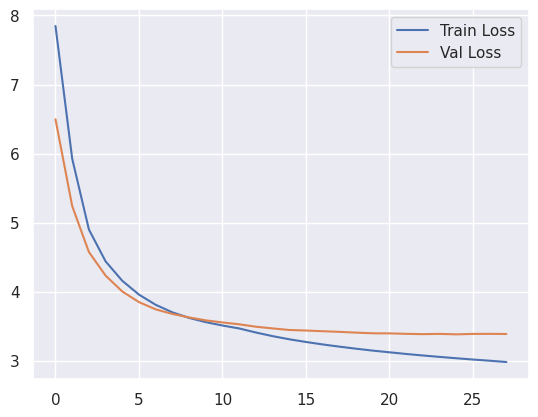

In [ ]:


# Train the model
history = model.fit(train_batches, epochs=100, validation_data=val_batches, callbacks=[early_stopping,model_checkpoint_callback])

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
class Summarizer(tf.Module):
  def __init__(self, tokenizer, transformer):
    self.tokenizer = tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS_RECAP):

    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizer.tokenize(sentence)
    sentence_tokens = sentence.merge_dims(-2,-1)
    sentence_tokens = add_start_end(sentence_tokens)

    sentence = sentence_tokens.to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    # start_end = self.tokenizer.tokenize([''])[0]
    start_end = tf.convert_to_tensor(np.array([START,END]), dtype=tf.int64)

    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())

      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # We had to add in detokenise for this tokenizer. The to_tensor() call
    # converts a RaggedTensor into a normal Tensor.
    tokens = self.tokenizer.detokenize(output).to_tensor()
    # The output shape is `(1, tokens)`.
    tokens = np.array([b.decode("utf-8") for b in tokens[0].numpy()])  # Shape: `()`.

    text = " ".join(tokens[1:-1])

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
#@title Create a summarizer by combining the tokenizer and the transformer
summarizer = Summarizer(en_tokenizer, model)


In [ ]:
#@title Show an example prediction and compare it to the ground truth
def print_summary(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {" ".join([ tokens])}')
  print(f'{"Ground truth":15s}: {ground_truth}')



sentence = 'In the media immersion lab (Spinner is listening to Craig\'s new CD.)'
target_recap = 'Downtown Sasquatch has a wedding gig, and Craig decides to put all of his focus on the music, but things get complicated when Manny and Ellie vie for Craig\'s attention. Meanwhile, Joey has a date with the bride\'s sister but wonders if he\'s too old for her when he overhears her friends gossiping about him.'
transcript = 'In Craig\'s garage, the band is practicing Craig: (Singing) Well somebody better stop me \'cause my feet don\'t touch the ground. I can\'t keep my hands off of you and there\'s nothing I can do- (The sound is really off and Craig gives them a weird look.) Craig: (Singing) I can\'t keep my hands off of you. Craig: Alright stop. Stop! Jimmy, look unless your last name is Hendrix and you\'ve come back to rock us from the grave. No solos while I\'m singing! Marco: We\'re never gonna get a wedding job.'
summarized_text, translated_tokens, attention_weights = summarizer(  tf.constant(transcript))
print(summarized_text)
print_summary(transcript, summarized_text, target_recap)

carly and jack are both upset when jack tells her that he is going to tell jack the truth about parker ' s death . jack tells parker that he is going to be a good person to get him to help him . jack tells parker that he will be a good man for parker ' s life . jack tells parker
Input:         : In Craig's garage, the band is practicing Craig: (Singing) Well somebody better stop me 'cause my feet don't touch the ground. I can't keep my hands off of you and there's nothing I can do- (The sound is really off and Craig gives them a weird look.) Craig: (Singing) I can't keep my hands off of you. Craig: Alright stop. Stop! Jimmy, look unless your last name is Hendrix and you've come back to rock us from the grave. No solos while I'm singing! Marco: We're never gonna get a wedding job.
Prediction     : carly and jack are both upset when jack tells her that he is going to tell jack the truth about parker ' s death . jack tells parker that he is going to be a good person to get him to help him

In [ ]:
#@title Example of ROUGE-1 and ROUGE-L
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
print(scores)

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765), 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}


In [ ]:
#@title Some utilities for plotting and displaying results
np_config.enable_numpy_behavior()


def transcript_to_tokens(transcript):
  in_tokens = tf.convert_to_tensor([transcript])
  in_tokens = en_tokenizer.tokenize(in_tokens)

  in_tokens = en_tokenizer.detokenize(in_tokens).to_tensor()[0]
  return in_tokens.reshape(in_tokens.shape[0])

def get_attention_head(attention_weights, head_id):
  attention_heads = tf.squeeze(attention_weights, 0)
  return attention_heads[head_id]


def plot_attention_head(in_tokens, summary_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  summary_tokens = summary_tokens[1:]

  n_rows = len(summary_tokens)
  n_cols = len(in_tokens)
  fig, ax = plt.subplots(figsize=(int(n_cols/3),int(n_rows/3)))

  ax.matshow(attention[:n_rows, :n_cols])
  ax.set_xticks(range(n_cols))
  ax.set_yticks(range(n_rows))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels( labels, rotation=90)

  labels = summary_tokens
  ax.set_yticklabels(labels)

  plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
print("Loaded a checkpoint from %s." %checkpoint_filepath)

Loaded a checkpoint from /content/gdrive/My Drive/ml_course/hw5_tuned/models/summarizer/checkpoints.


Example 1 of 20: 
Input:         : Nick: What are you guys doing out here?
Prediction     : nick and sharon are on the phone when they find out that they are going to be together . nick tells her that he is going to be a good person . nick tells her that he is going to be a part of the newman family . nick tells her that he is going to be a good person for the kids
Ground truth   : Gloria continues to work her magic with getting in with Jeffrey so she can find out what he is up too. The doctor gives Victoria bad news. And lets them know they have no time. He has to do something now or they will lose both the baby and Victoria. Nick watches over David with Nicky. Neil is happy to invite Karen to Thanksgiving dinner. She is very excited about it until she overhears a conversation with Lilly and Devon. She cancels.
ROUGE1_precision: 0.32
ROUGE1_recall: 0.23
ROUGE1_fmeasure: 0.27
ROUGEL_precision: 0.18
ROUGEL_recall: 0.13
ROUGEL_fmeasure: 0.15


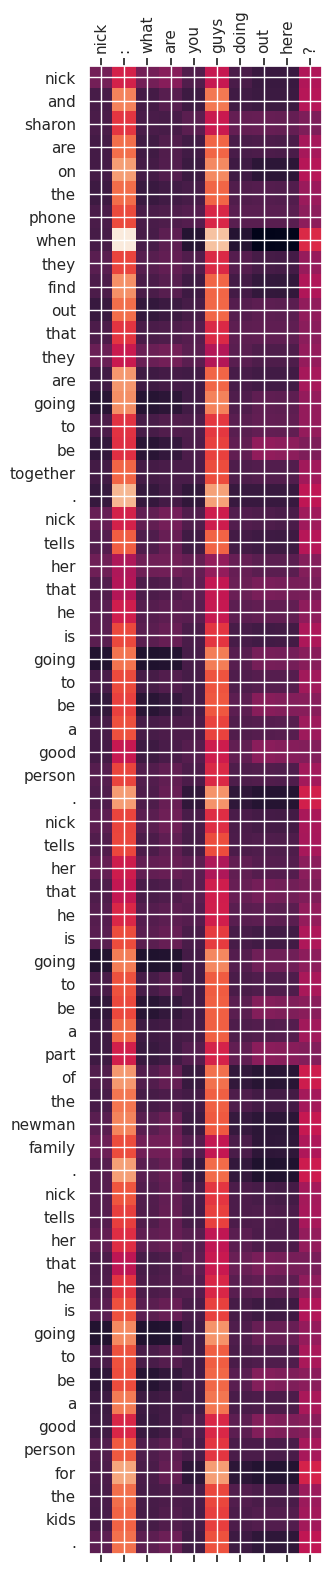

Example 2 of 20: 
Input:         : Julian: How did I get from following Tabitha on the wharf to here? Wherever here is.
Prediction     : theresa and ethan are both in the hospital after theresa and ethan are gone to the hospital . theresa is upset that ethan is the father of her baby . theresa is upset that ethan is the father of ethan ' s baby . ethan and theresa are both upset that ethan is the father of ethan ' s baby . theresa is
Ground truth   : Eve found out that the BM is her son. She said that she would help him start the healing process if he turned himself in. Of course he doesn't want to. He showed her something that happened to him and Eve was shocked. Julian now knows Tabby's secret. Julian was held hostage by the bad witches. Tabby had to save him because Endora wanted her to. Julian isn't very pleased but seems to be accepting of it. Theresa still wont tell Ethan her secret. Ethan begs her and says nothing would separate them. He leaves to see Gwen to get a divorce and t

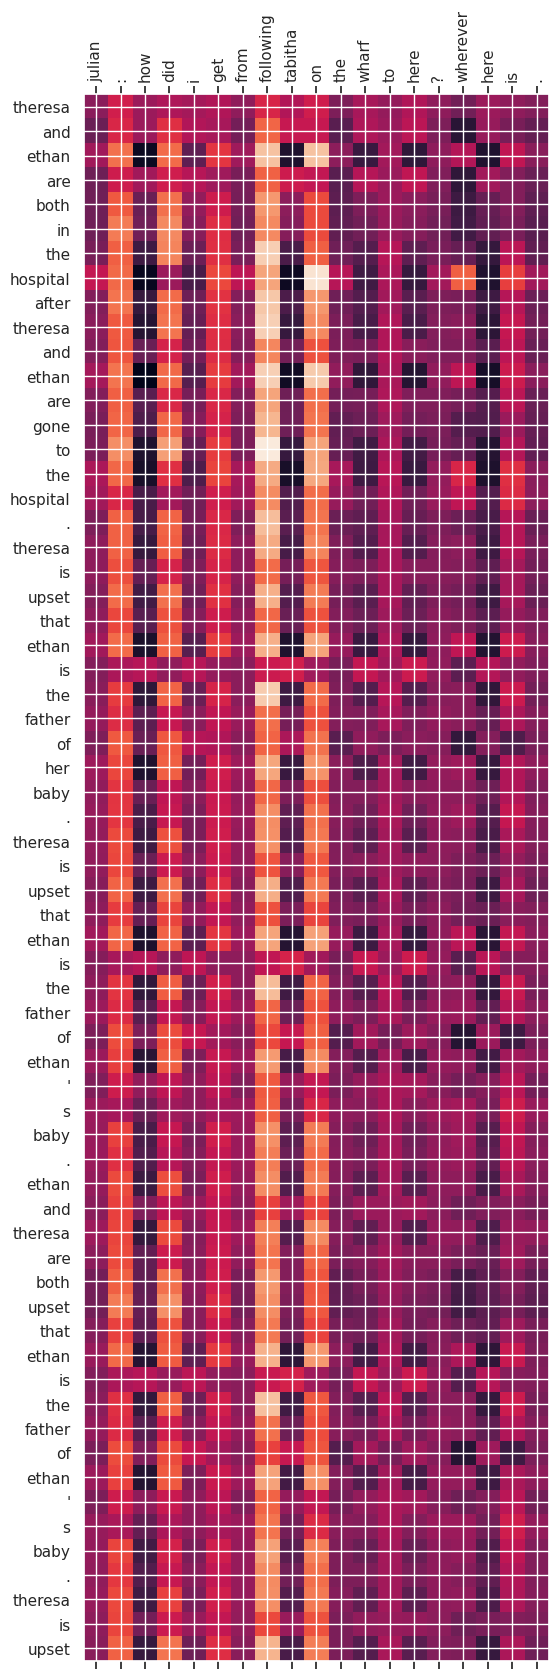

Example 3 of 20: 
Input:         : Gwen: Sorry, sorry I'm late. I overslept.
Prediction     : gwen and will continue to argue about how to get back together with gwen . gwen and will talk about how they can get back together . gwen and will talk about their relationship . will and gwen talk about will and gwen ' s relationship . will and gwen talk about will and gwen ' s relationship . will
Ground truth   : Will worries that he tipped their hand to Barbara in order to rub her face in it. Gwen assures him that she can't hurt them anymore. She then shows him that she went and opened a savings account in both their names. They feel untouchable, but they regret feeling that way later when Lisa is forced to let Gwen go because it appears she stole a diamond necklace of one of her guests. Little did Lisa know, Barbara found the necklace and set Gwen up. Gwen sees Barbara and accuses her of being behind it though. Emily and Henry continue to shadow Meg. Henry charms a maid and finds out Meg d

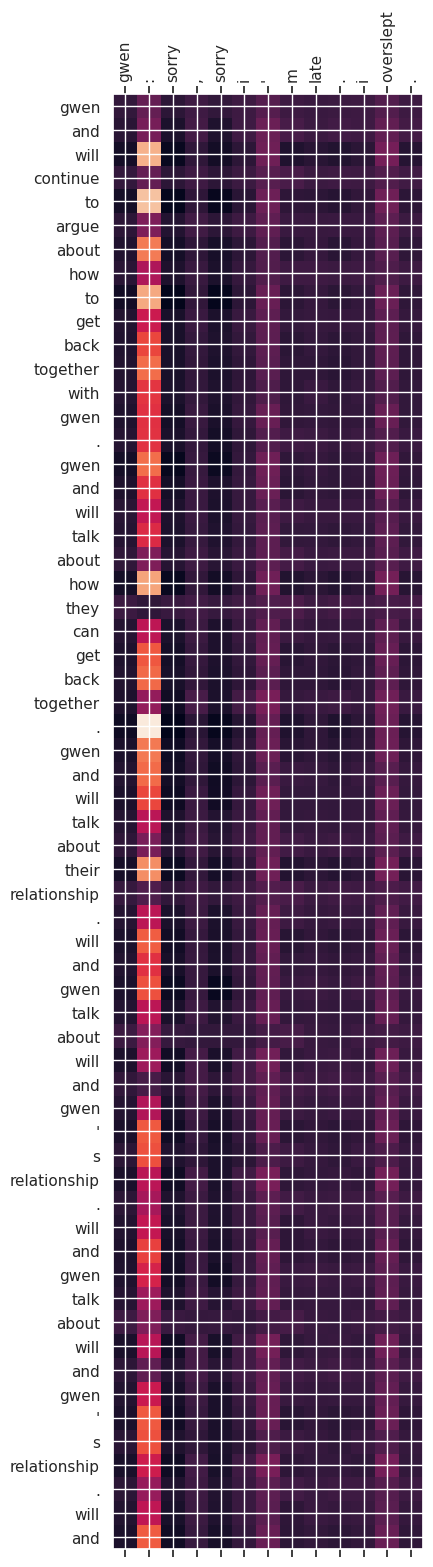

Example 4 of 20: 
Input:         : (Electricity crackling)
Prediction     : the doctor and rose return to the charlotte to find a way to find a way to save the charm . they find a way to find a way to stop the shady of the charm , and the doctor is forced to reveal the
Ground truth   : Andy continues to taunt Ridge with the electrical rod and says if he goes to the police it will be the biggest shock of Ridge's life. Andy had an accomplice to find the key, wouldn't Ridge like to know who it was? If he goes down, he will take someone else to hell too. He is displaying the key and talking to the pigeons as little birdies when a security guard comes out, distracts him and the pigeons fly toward his face and Andy falls backwards to an electrical transformer death. Ridge returns to Brooke's house where he slowly tells her Andy won't be a threat anymore, he's dead. And the worst part about it was that someone served her up on a silver platter by telling him where her key was.
ROUGE1_precisio

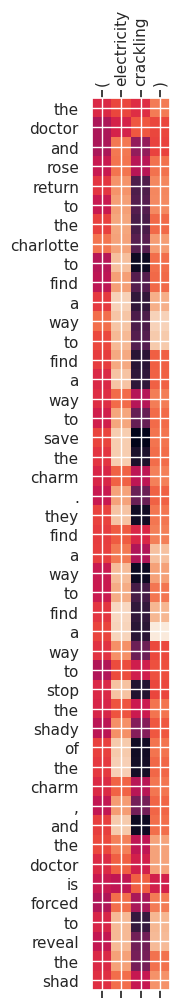

Example 5 of 20: 
Input:         : [PREVIOUSLY_ON]
Prediction     : reva and josh are talking about reva . reva is talking to josh about the baby . reva tells josh she is going to tell josh about the baby . josh tells reva he is going to tell her the baby . reva tells josh she is not going to tell josh the truth . josh tells reva he is going to tell
Ground truth   : Cris asks Jen if she was working with Mitch, but she plays innocent. He asks about the champagne glasses but she sticks to her story. Sam pays a visit to Mitch and roughs him up a little, warning him away from his children. Mitch claims that Jen came to him, then Jen shows up at Mitch's door. Jen still claims that the article is not true, but Sam doesn't believe her. He says he loves her no matter what and begs her to confide in him. Natalie consoles Viki, who is upset about Jessica's departure. Todd and Blair bicker over where she's jealous or not. Shana shows up so Blair hides. Shana and Todd flirt heavily. Blair is upset

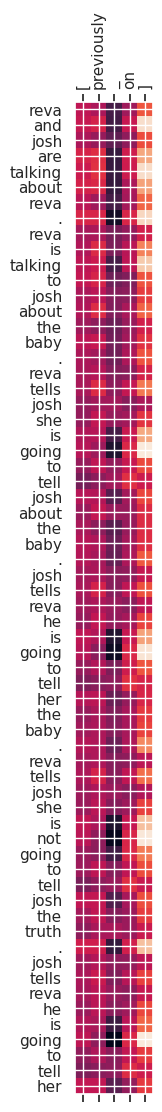

Example 6 of 20: 
Input:         : Sam: Yeah, ivy. Look, they had my credit card, ok? So I'll be home as soon as I can. Ok. All right, bye. Chad, I'm surprised you're still here.
Prediction     : theresa and whitney argue about what happened to theresa . theresa and ethan talk about theresa and ethan . theresa and ethan argue about theresa and ethan . theresa and ethan argue about theresa and ethan . theresa and ethan argue about theresa and ethan . theresa and ethan
Ground truth   : Sam and Julian break up another fight between Chad and Fox. Paloma worries about her family not loving her. She talks to her Tia Maria and then runs into Chad on the docks. They talk about their family problems. She urges him to take Julian's job offer so he can use the money and power to take revenge on Julian, Eve and Fox. Fox and Whitney kiss passionately as she continues with her plan to make him the father of her baby. Sheridan, Luis, Pilar, and Martin find Alistair and Katherine on the floor and at f

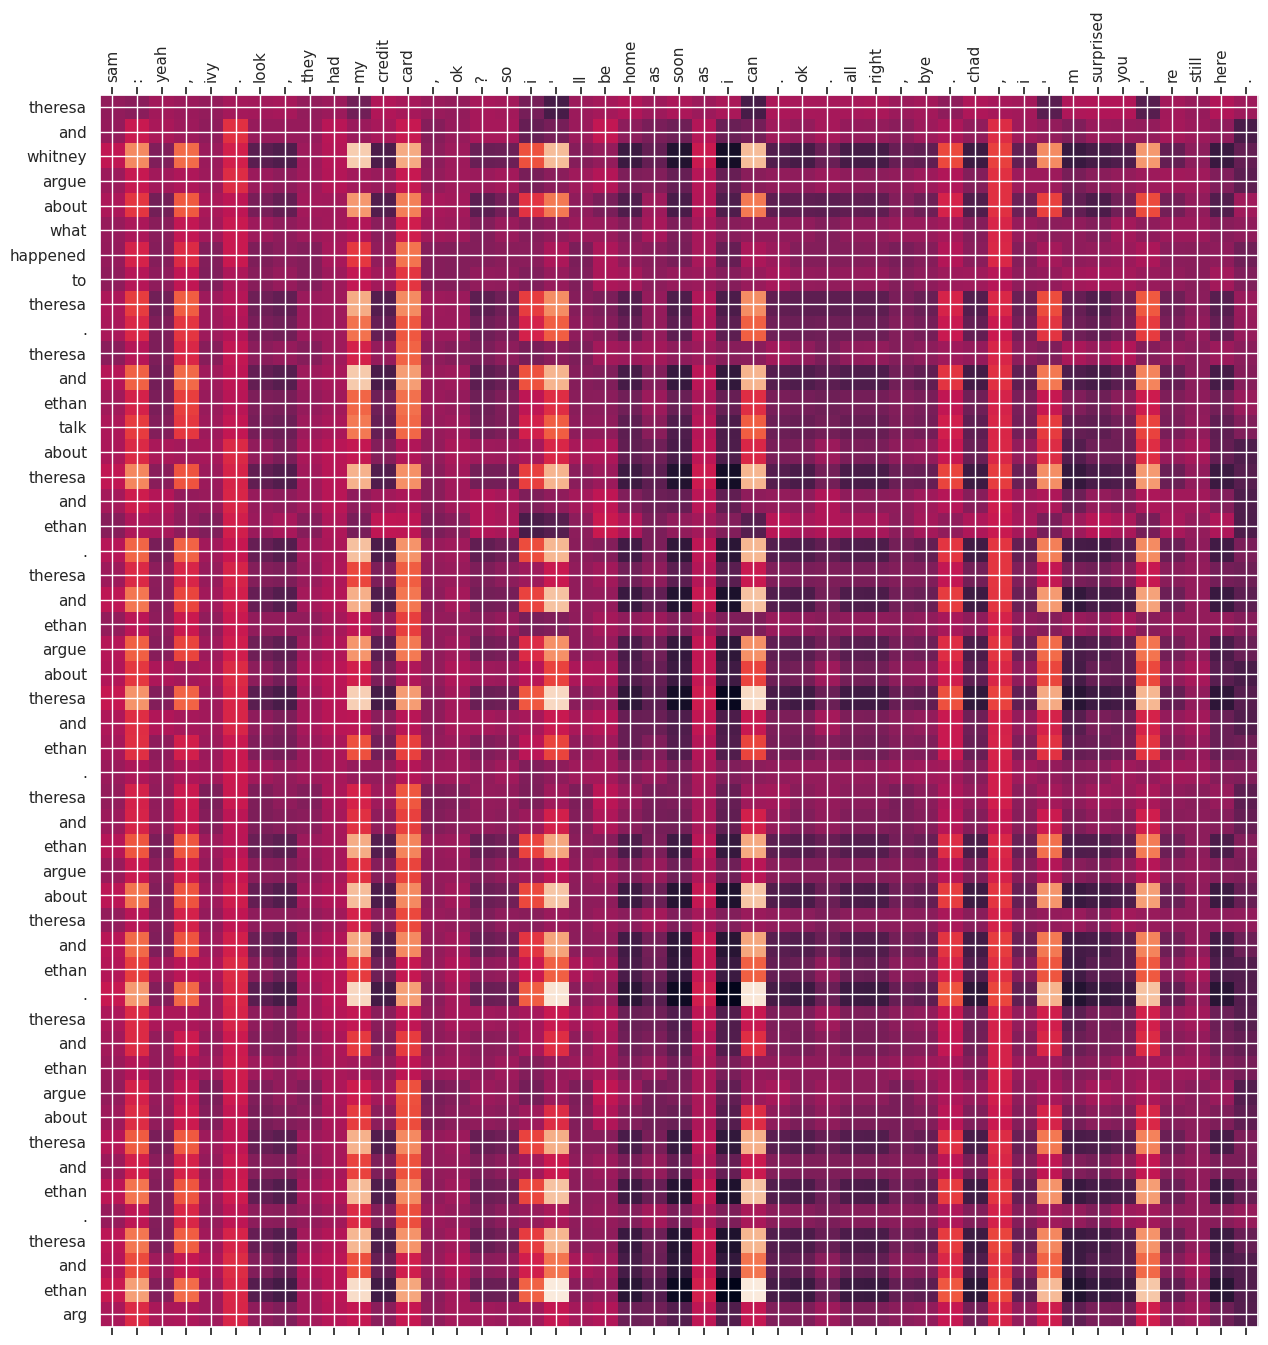

Example 7 of 20: 
Input:         : Pam: [to Jim] Hey. I feel so lucky we're in the same city for Valentine's Day.
Prediction     : phoebe and christopher meet up with a new man named karen . they discuss the situation with their new boyfriend , and their new boyfriend , who is a threat . they discover that the new contract is a model for the first time , and they are
Ground truth   : The office pairs into couples so that they may all be able to take advantage of a Valentine's Day discount at a mini-mall. After Andy returns from his boat trip, Erin decides that she is going to break up with him so that she can be with Pete, but Pete begins to doubt her. Pam and Jim share lunch with Brian, the documentary's sound man.
ROUGE1_precision: 0.28
ROUGE1_recall: 0.18
ROUGE1_fmeasure: 0.22
ROUGEL_precision: 0.12
ROUGEL_recall: 0.07
ROUGEL_fmeasure: 0.09


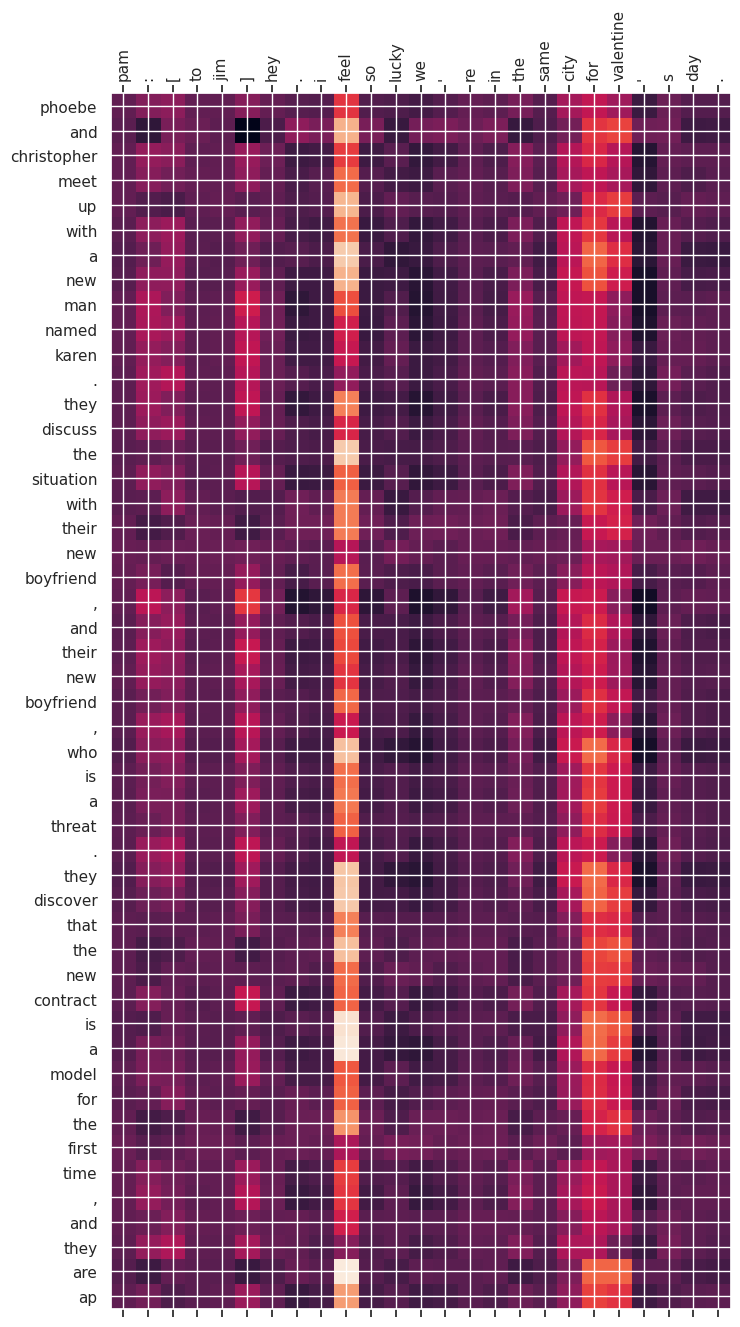

Example 8 of 20: 
Input:         : Sami: [Sobbing]
Prediction     : sami and lucas argue about sami . sami and ej argue about sami . ej and sami argue about sami ' s condition . ej and sami argue about sami ' s death . ej and sami argue about sami ' s death . ej and sami
Ground truth   : Sami is hesitant to tell Lucas why she is truly upset about the new baby. While Lucas is out buying celebratory supplies, EJ calls Sami to gloat about being back in town. EJ walks into Roman's office but denies having shot John. Roman has EJ booked and put in a cell. Chelsea has Nick, Abby, and Billie join her at the pub and announces her plan to start attending college. Billie gets angry and leaves when Chelsea teases her about her secret lover. Nick makes an excuse to leave and runs after Billie to talk.
ROUGE1_precision: 0.38
ROUGE1_recall: 0.16
ROUGE1_fmeasure: 0.22
ROUGEL_precision: 0.31
ROUGEL_recall: 0.12
ROUGEL_fmeasure: 0.18


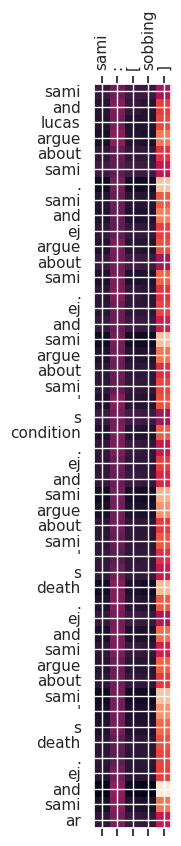

Example 9 of 20: 
Input:         : Act One.
Prediction     : frasier is in a suitable mood , and he is approached by a woman who is abandoned in a modeogist , and frasier is abducted by a model . he is apologist , and frasier is
Ground truth   : Frasier is told a rumor that one of the KACL on-air staff is getting fired. When sportscaster Bob 'Bulldog' Briscoe is called into a meeting with management, Frasier assumes the rumor is true and accidentally reveals it to him. As a result, Bulldog quits the station while Frasier learns that his job was actually safe. Feeling guilty and feeling pressure from Martin, Frasier decides to go to the station manager and beg for Bulldog's job back, only to learn the rumor was true and it was actually Frasier who was about to be fired.
ROUGE1_precision: 0.44
ROUGE1_recall: 0.15
ROUGE1_fmeasure: 0.22
ROUGEL_precision: 0.34
ROUGEL_recall: 0.11
ROUGEL_fmeasure: 0.17


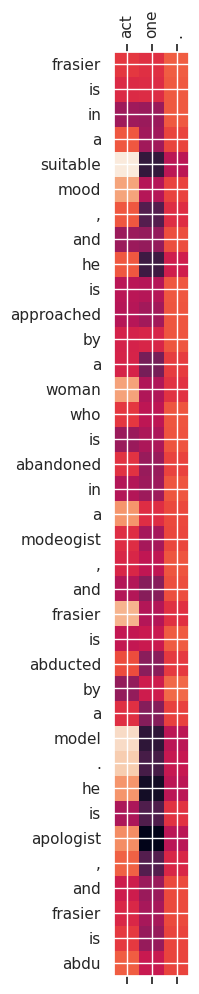

Example 10 of 20: 
Input:         : (Part of this is missing due to local news...we'll try to get it up later)
Prediction     : jack and phyllis are on the phone when jack comes in to join them . jack asks phyllis if she is going to get him to the hospital . phyllis tells jack that she is going to get a call from victor . jack tells her that he is going to get a visit from victor . jack tells jack that he
Ground truth   : Victor has a meeting with Scott to find out what he knows about Abby and her business dealings. Just as Scott is about to answer him, Abby interrupts them. Lily and Juliet have a chat about the hockey team. Lily and Juliet want to see the footage of the commercial but Cane tells them that is not possible right now. They wonder why. In the hotel room, Billy texts Phyllis to see where she is. Phyllis and Victoria are within inches of each other down in the lobby. Hilary interrupts Victoria and ask about the commercial. At the Coffeehouse, Sharon brings Nick a pastry and

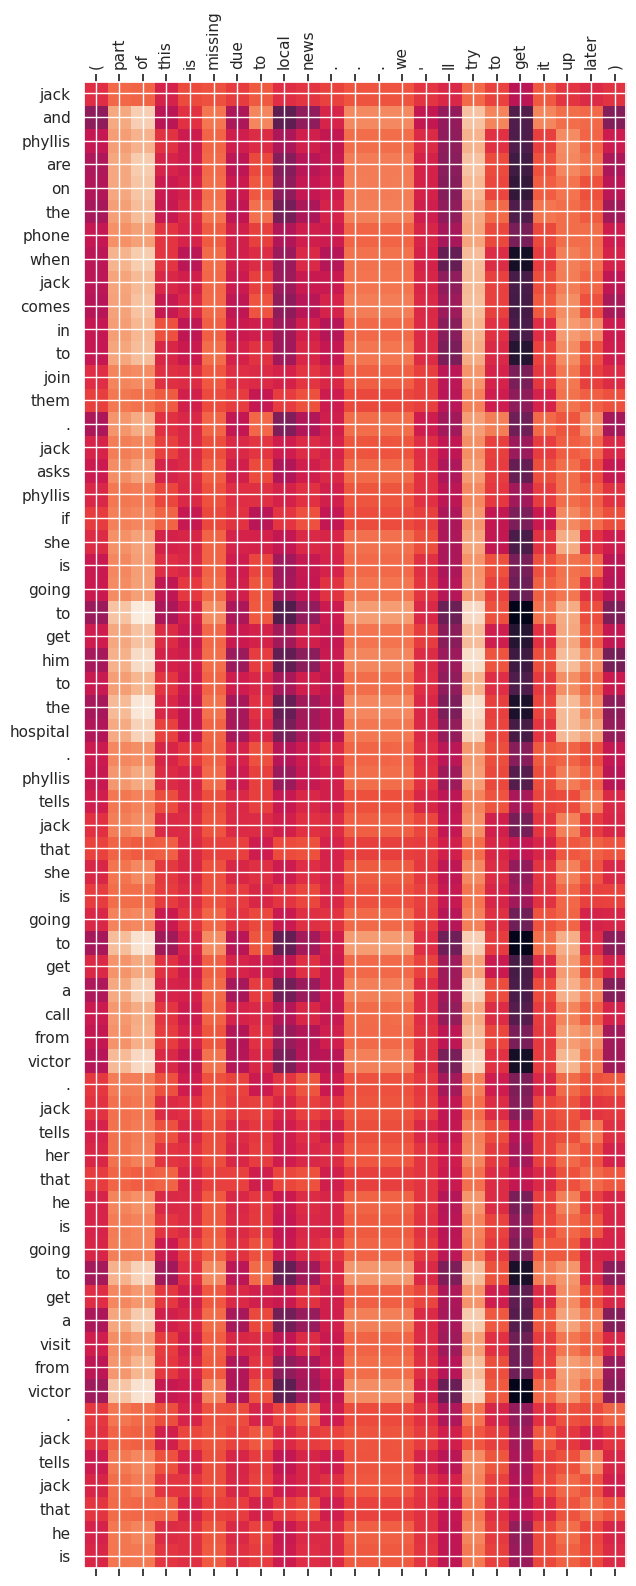

Example 11 of 20: 
Input:         : Adriana: Are you asleep?
Prediction     : john and natalie arrive at the chapel . they discuss the fact that they are going to be together . they are both surprised that they are going to be together . they are both surprised that they are going to be together . they are also there and they are also there .
Ground truth   : Marty reveals to John how that she had never told anyone, including Cole that Patrick had been murdered. Blair and Todd begin to give in to their emotions, but pull apart and agree that making love would be a bad idea. Rex refuses to make love to Adriana because he feels it would hurt the baby. Alex refuses to marry David. Adriana laughs when she finds out that Rex had thought she was pregnant. Adriana reveals that she had been doing research to do a maternity line. Nora reveals that she had answered Clint's cell phone and it had been Dorian. Clint assures her that she had not done anything wrong . John tries to console Marty afte

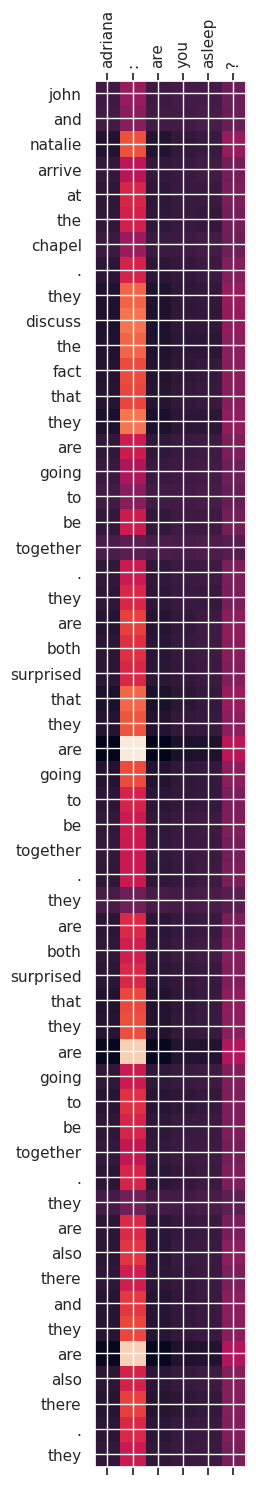

Example 12 of 20: 
Input:         : Deacon: What is Liam doing here?!
Prediction     : steffy tells liam that she is not going to tell him that she is not going to tell him . he says he is not going to be with her . he says he is not going to be with her . he says he is not going to be with her . he says he is not going to be with her
Ground truth   : Deacon barks at Quinn and demands to know why Liam is here. She better start talking or he will. She explains how he fell, has memory loss, she played nurse and he does not know who he is or who she is. He laughs at that. Thomas is glad that Steffy finally showed up at the office. She said she was enjoying herself on the beach with Wyatt. He's surprised when she says Wyatt even proposed today. She's really lucky to have him in her life. Caroline asks Wyatt where is MIA Quinn. He says since the divorce he has not been able to keep up with her. He does tell her that he proposed to Steffy. He is not pressuring her for quick answer. And he wi

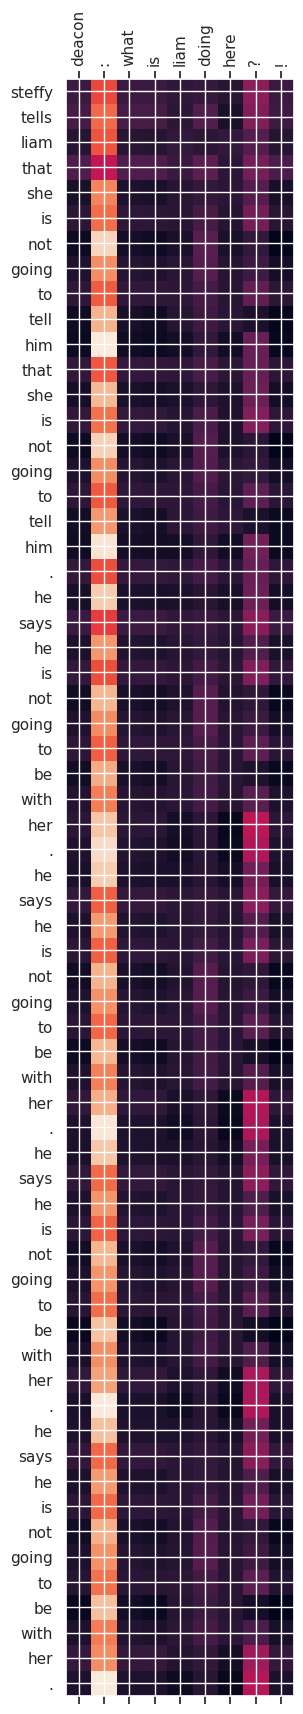

Example 13 of 20: 
Input:         : •I do not own the characters or situations of BTVS, and I claim no credit for the content of this episode. I have merely transcribed what appeared on my screen, with help from the closed captions. •I prefer that you link to this transcript on the Psych
Prediction     : the doctor and amy arrive in the shady store in the shady store . they discover that the charmed ones are appreciative . they discover that the charmed ones are a model , and they find
Ground truth   : The Scoobies discover Spike's new robot toy; Glory's minions kidnap Spike, thinking he is the Key, and when they realize he isn't they torture him for information. Buffy and Giles go on a discovery quest about the origin of the Slayer. Buffy is told ominously that "Death is your gift".
ROUGE1_precision: 0.33
ROUGE1_recall: 0.21
ROUGE1_fmeasure: 0.26
ROUGEL_precision: 0.15
ROUGEL_recall: 0.09
ROUGEL_fmeasure: 0.12


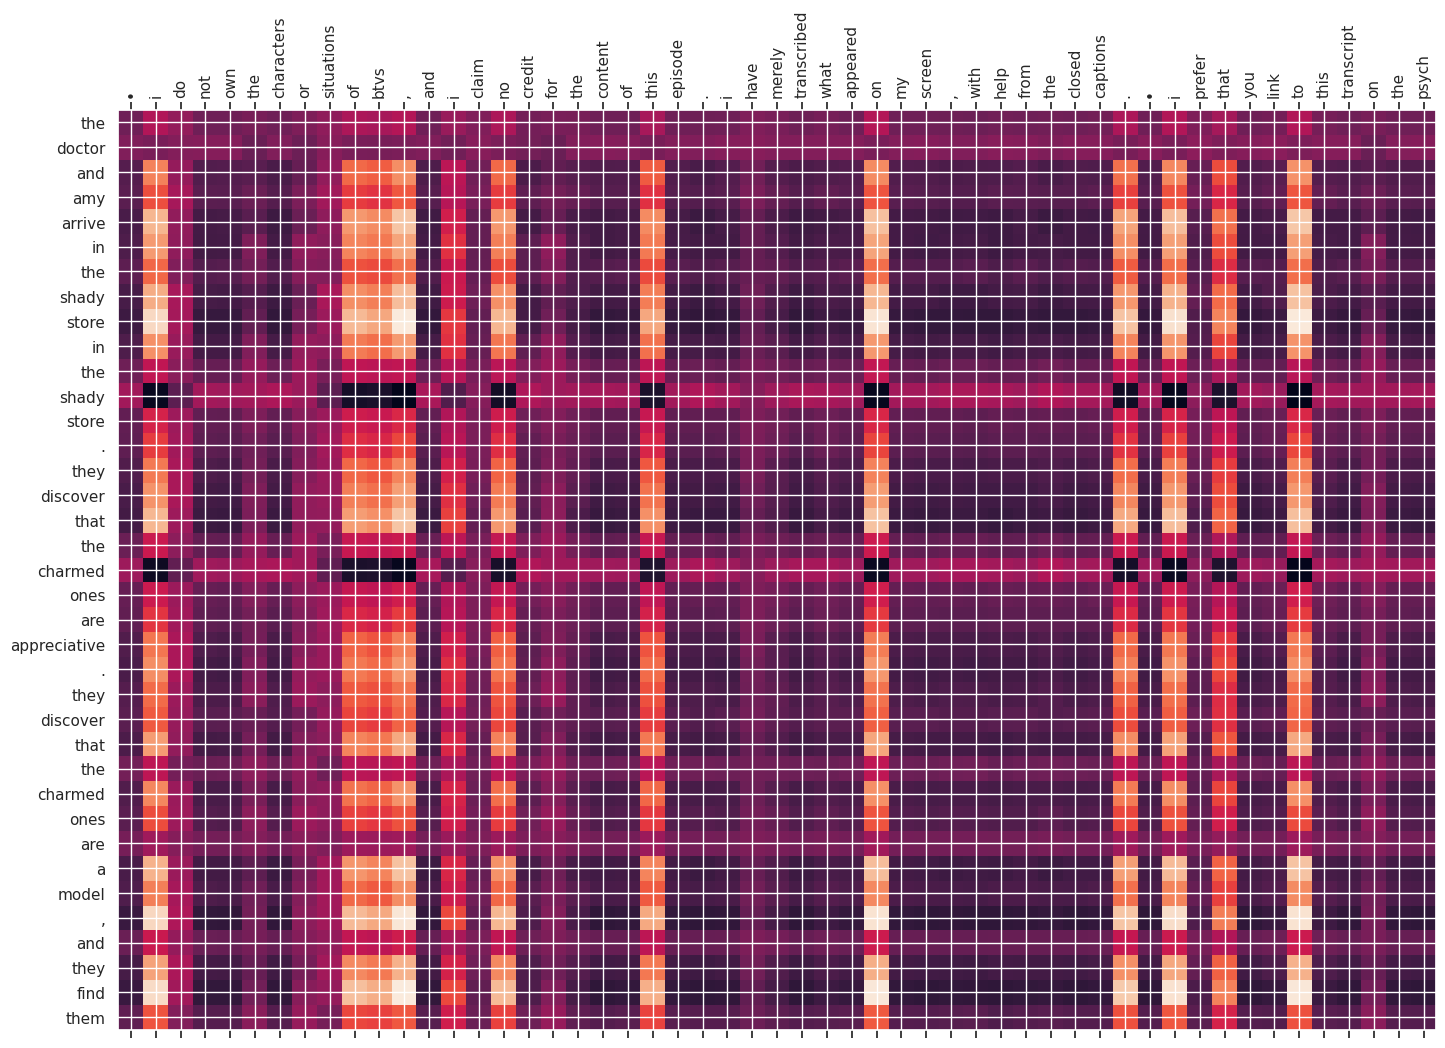

Example 14 of 20: 
Input:         : Natalie: Wait -- what are you doing?
Prediction     : blair and todd are in the hospital . they are both in the hospital . they are in the hospital and they are there . they are there . they are there . they are there . they are there . they are there . they are there . they are there . they are there . they are there . they are
Ground truth   : Starr gets Mathew to fake being sick so the police van holding her father will stop so she can help him get away. Dorian goes with Blair to the police because they say Starr ran away. Nora tries to convince Evangeline that Todd is guilty. Nora tells Evangeline that if she continues this case she will lose because she is determined to put Todd away. Roxy talks to Natalie about how she should go and see John. Natalie tells her that she is not ready to move on from Christian.
ROUGE1_precision: 0.12
ROUGE1_recall: 0.07
ROUGE1_fmeasure: 0.09
ROUGEL_precision: 0.08
ROUGEL_recall: 0.04
ROUGEL_fmeasure: 0.06


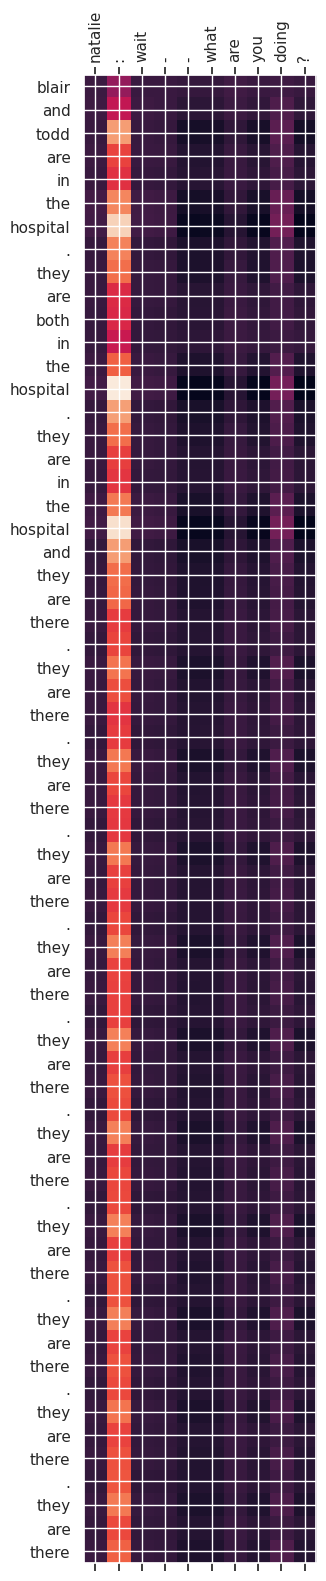

Example 15 of 20: 
Input:         : Katie: Mike, you ready?
Prediction     : katie is upset when she finds out that mike is not going to tell her the truth about her and simon . katie tells simon that she is not going to tell simon the truth . simon tells simon that simon is the one who is the one who is simon . simon tells simon that simon is the one who is simon
Ground truth   : Dusty threatens to make a scene. Hal learns that there is a nun in the non- Catholic church. Lily is incited to violence. Lucinda agrees to be a part of the wedding party. Paul has special glasses and champagne. Rose forgets to bring her shoes.
ROUGE1_precision: 0.15
ROUGE1_recall: 0.20
ROUGE1_fmeasure: 0.17
ROUGEL_precision: 0.10
ROUGEL_recall: 0.13
ROUGEL_fmeasure: 0.11


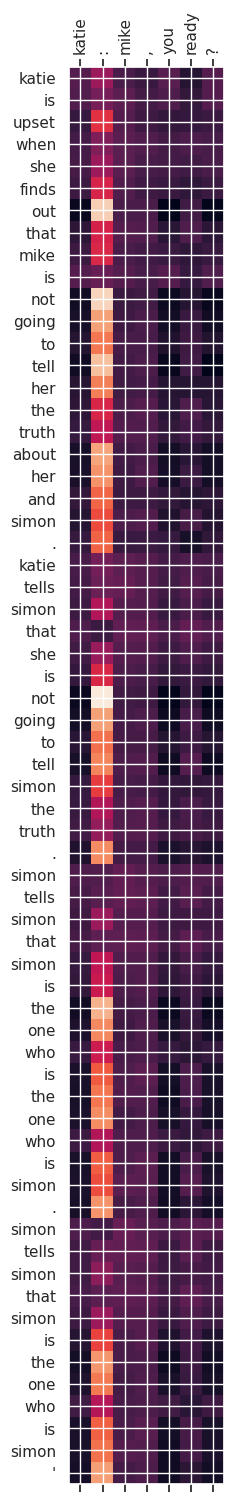

Example 16 of 20: 
Input:         : Whip: You told him?
Prediction     : ridge tells brooke that he is not going to tell brooke about the kiss . he says he is not going to be with her . he says he is not going to be with her . he says he is not going to be a good man . he says he is not going to be a good man . he says
Ground truth   : Whip is livid that Taylor is sharing the details of their sex life with her ex-husband. He feels Ridge is more than a minor preoccupation with her. She says she is sorry and was just not thinking. He realizes that she probably thinks she can share almost anything with Ridge, but he thinks the private intimate details of their sex life should be off limits. He points out that Ridge even laughed at him. Bill calls Oliver and tells him to hang in there about Hope. He is not finished with Liam yet. Oliver shoots hot, sexy photos of Brooke and Thomas. Thorne says Ridge ordered them, yet Ridge is aghast when he walks up and discovers them. He thinks it is too 

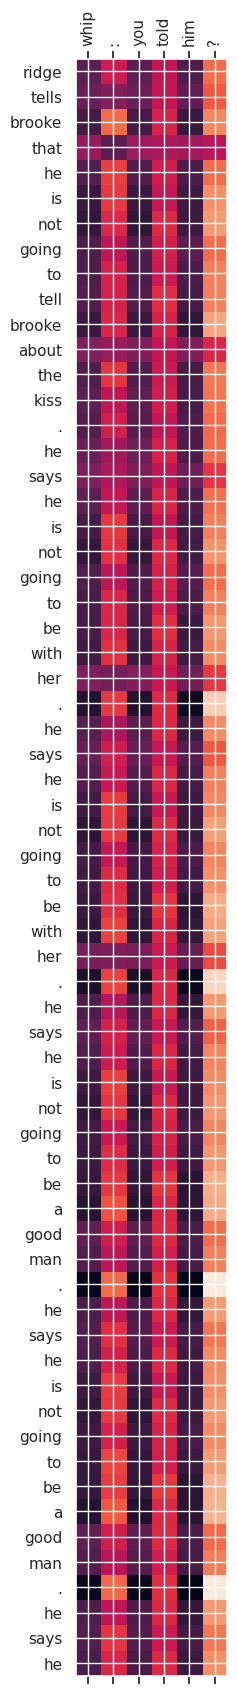

Example 17 of 20: 
Input:         : [N.B. The transcript has not been divided cleanly in half, owing to the extended length of the U.S. broadcast version. So, Acts One and Five have been transcribed by Nick Hartley, and Acts Two, Three and Four by Mike Lee.]
Prediction     : the doctor and rose return to the charlotte to find a way to get the charms from the charm . they find a way to get the third device . they find a way to get the third doctor ' s house . they find a
Ground truth   : While on a plane, Frasier meets a woman named Anne. They engage in conversation and in flashback, Frasier recalls the events preceding his plane ride: Frasier and Niles volunteer to put together a quick wedding for Martin and Ronee when the venue is only available for one day. Meanwhile, Frasier says farewell to Charlotte as she departs for Chicago. The wedding ceremony gets off to a rocky start when the guests are stranded outside in the heat and things get worse when Eddie swallows one of the rings. D

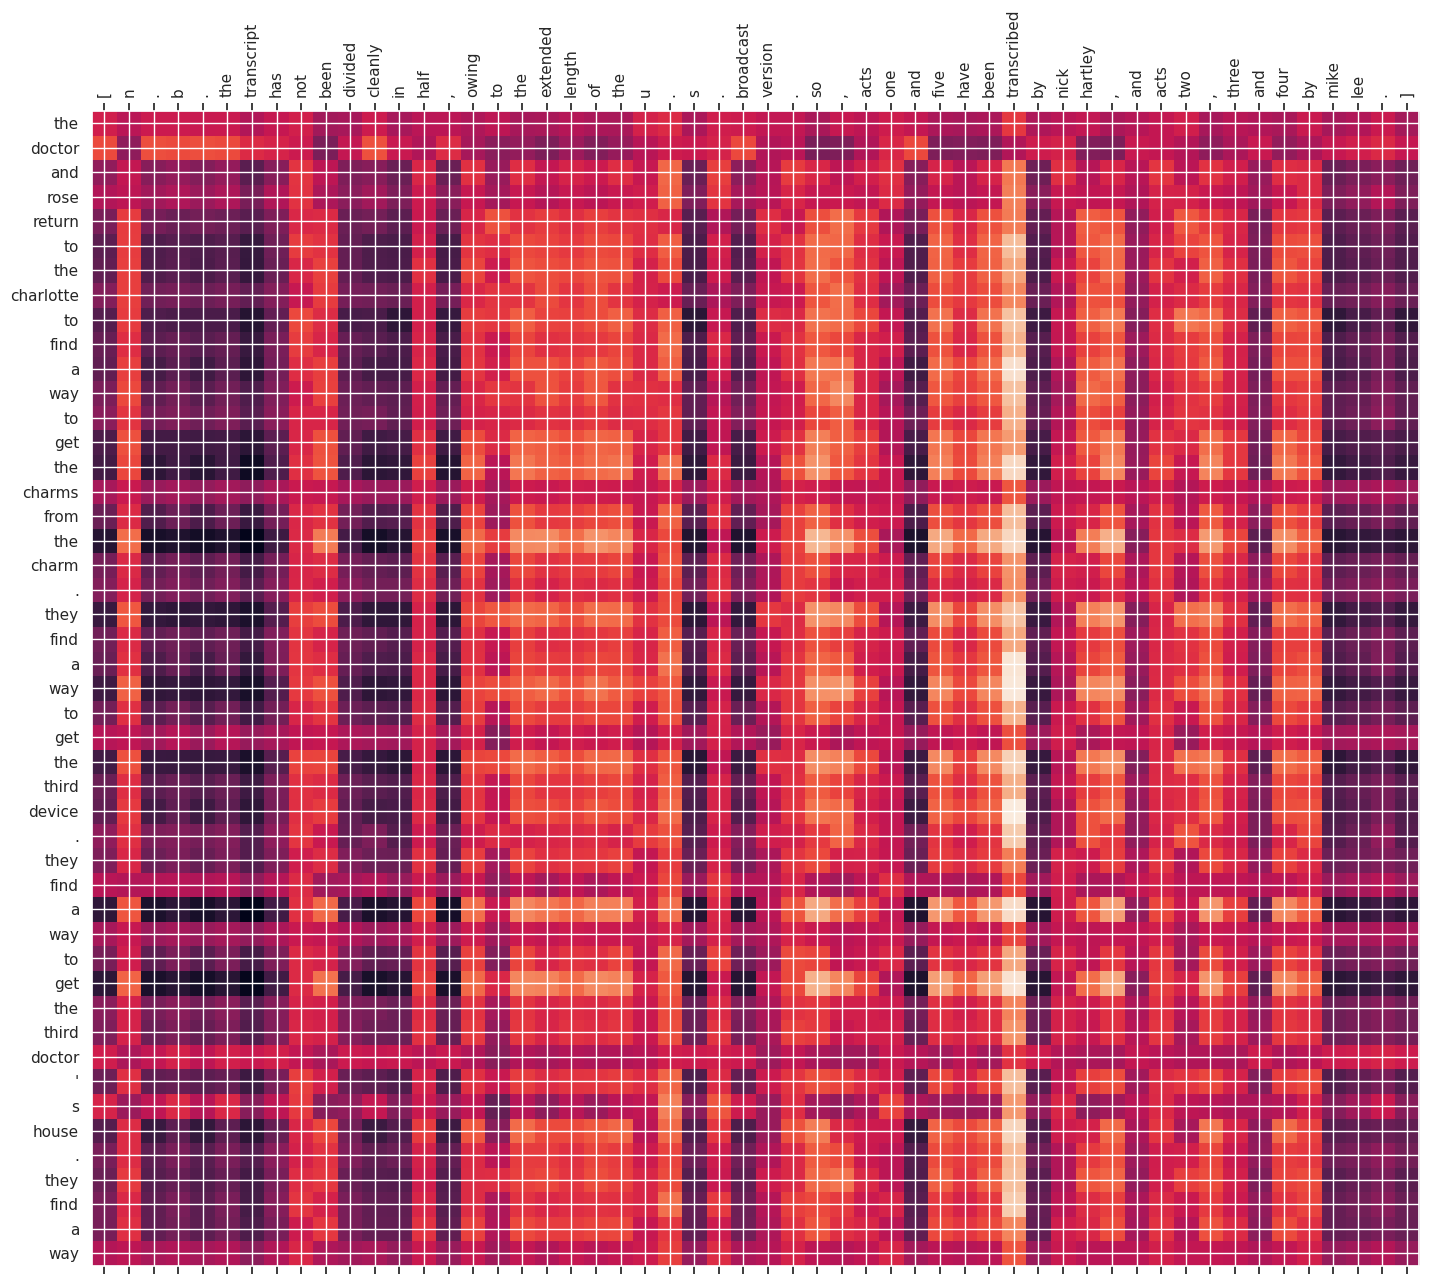

Example 18 of 20: 
Input:         : Victoria: With dad in jail, it's been so chaotic here. The media won't let up. The business pages are nailing Newman. And the department heads are bombarding me with questions. I'm sorry, but I don't have the answers.
Prediction     : sharon and nick discuss the fact that they are going to be together . nick and sharon discuss the fact that they are going to be together . sharon tells nick that she is going to be a part of the newman family . nick tells sharon that he is going to be a part of the
Ground truth   : Dylan gets Max to admit to the social worker that he exaggerated the truth to his teacher, because he was mad at Stitch who never hurt him. The social worker takes Max with her until the case is officially closed, but Abby worries that Max's false allegations will always hurt the family she and Stitch are trying to build together. Victoria asks Nick to come back to work for Newman Enterprises once the board votes to oust Victor as CEO. Nick 

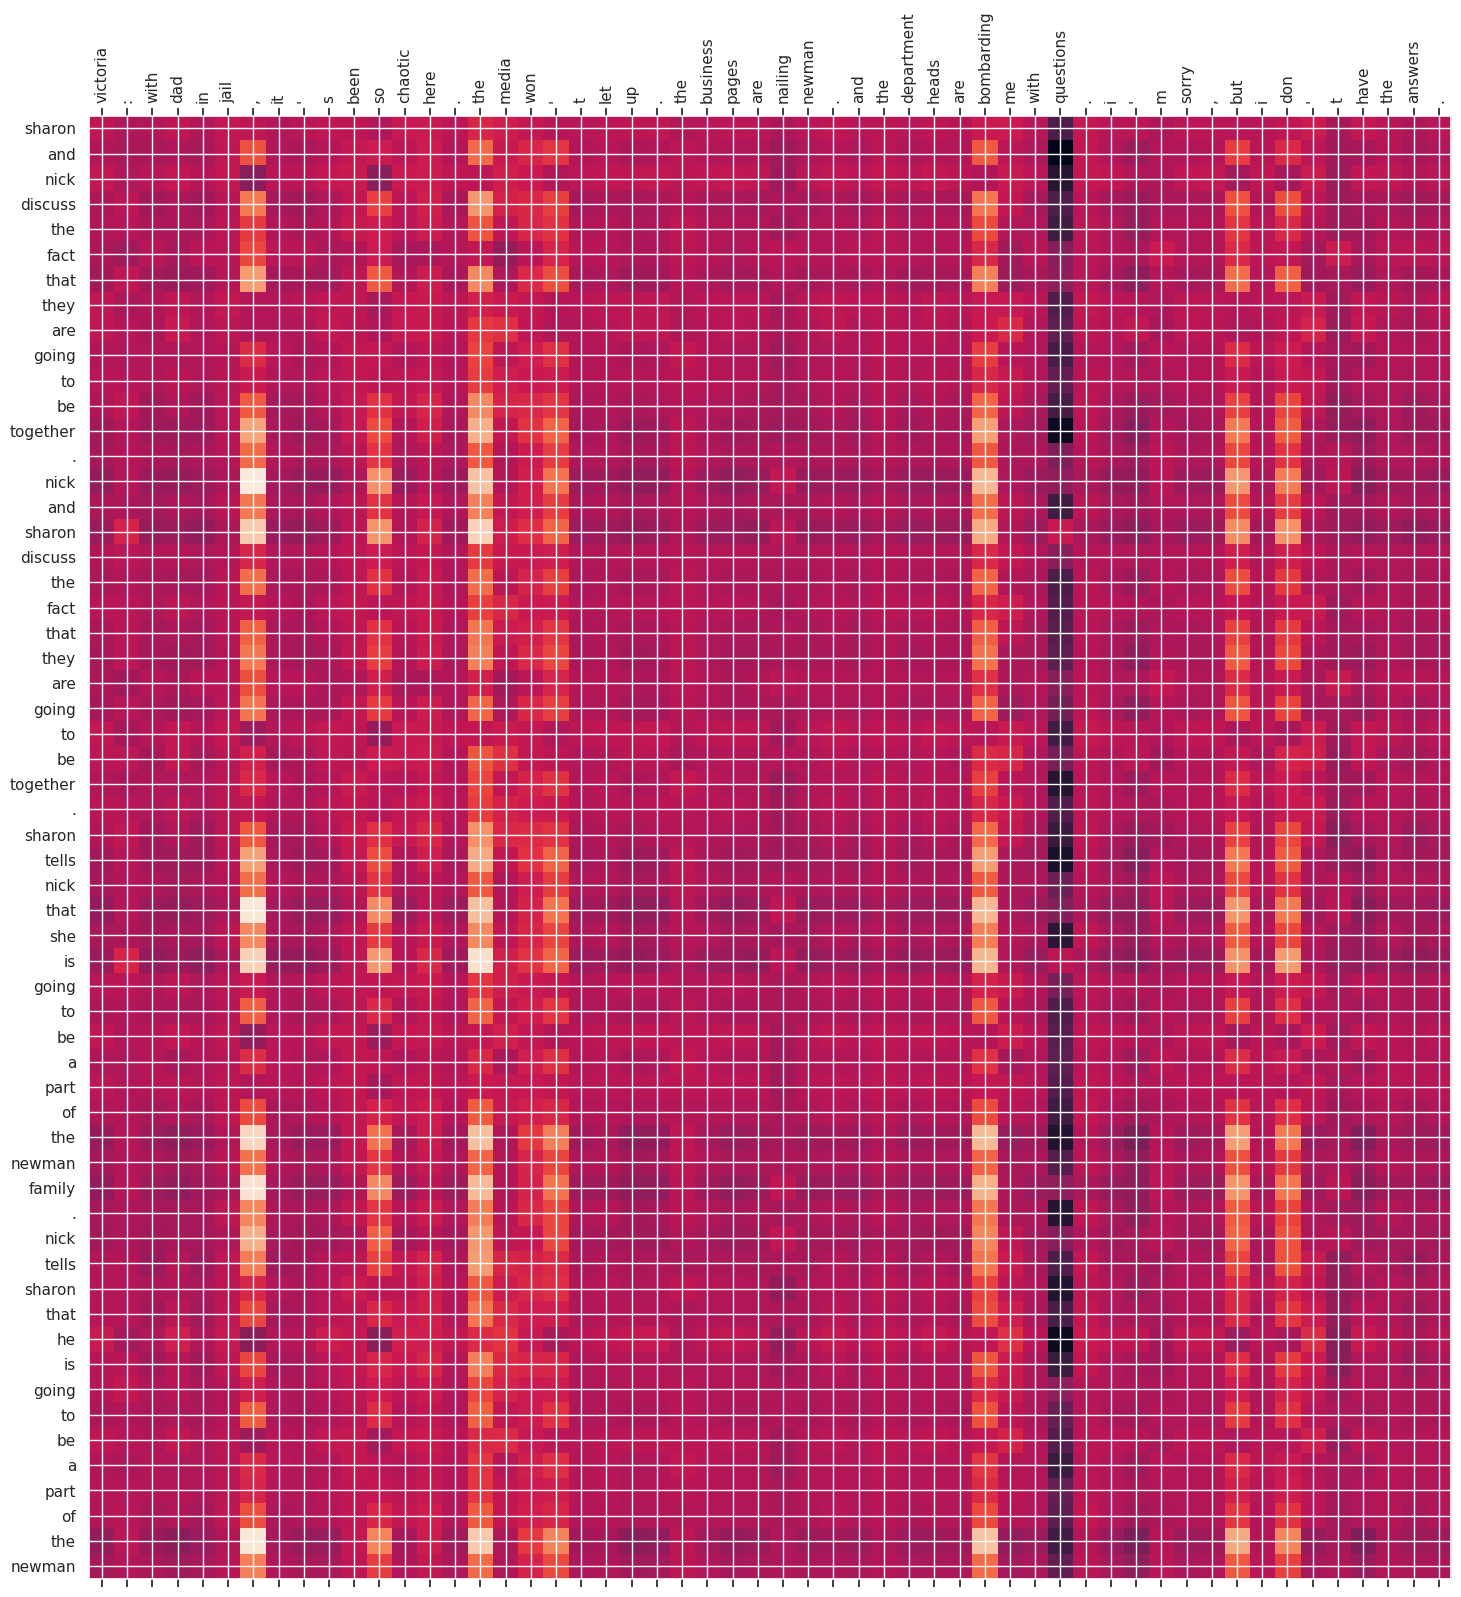

Example 19 of 20: 
Input:         : Jamal: Yeah, hold it steady and tie it tight, man.
Prediction     : jack and ashley argue about the fact that ashley is the one who is responsible for the death of the newman stock . ashley tells ashley that she is going to be a part of the newman family . ashley tells ashley that she is going to be with ashley . ashley tells ashley that she is going to tell
Ground truth   : With her new ring tucked out of sight, Christina makes a wish on a flower. When she wishes to go to the party, Ian tells her to come up with something else. She wishes for a ladybug, and one appears in her little hand. Lucy tries to make Kevin understand that their kiss didn't mean anything, but he wonders which one of them she's really trying to convince. He expresses concern about Ian's role in her life, and he worries that Christina will see his fangs someday. Lucy is prepared to deal with what it means to love a vampire. Ian eavesdrops for a moment and then joins them. Kevin 

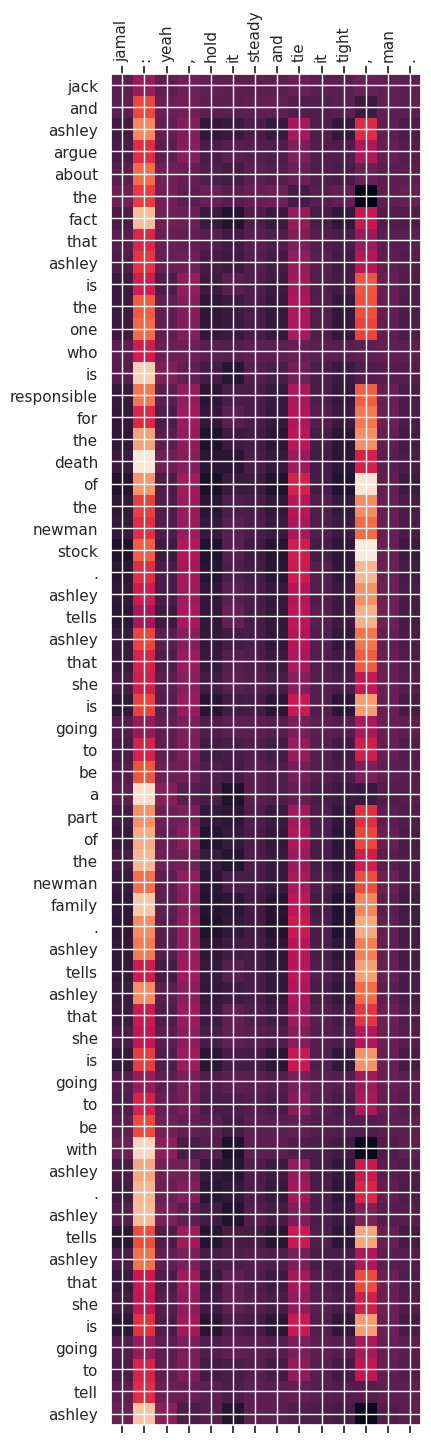

Example 20 of 20: 
Input:         : Nina: Hey, um, guess what? Our numbers -- they weren't just a fluke. Circulation is up, and the magazine is just jumping off the shelf. And, um, people are renewing their subscriptions, and also, our ad revenue is up for our next issue. Everything is reall
Prediction     : jack and erica are in the hospital . erica and jack are in the hospital . erica and jack are in the hospital waiting room . erica and jack are in the hospital . jack and erica are in the hospital . erica and jack are in the hospital . erica and jack are in the hospital . jack and erica are in
Ground truth   : Jason reveals he has real concerns about Jake's "real or alleged" fear of the break-in at the house and he seems to know the only person he can confide in about that is Sam. Elizabeth takes Jake to the hospital to consult with Dr. Kevin Collins who recommends a child therapist. Dr. Renault speaks with Jake then tells Elizabeth that her son is having difficulty communicating hi

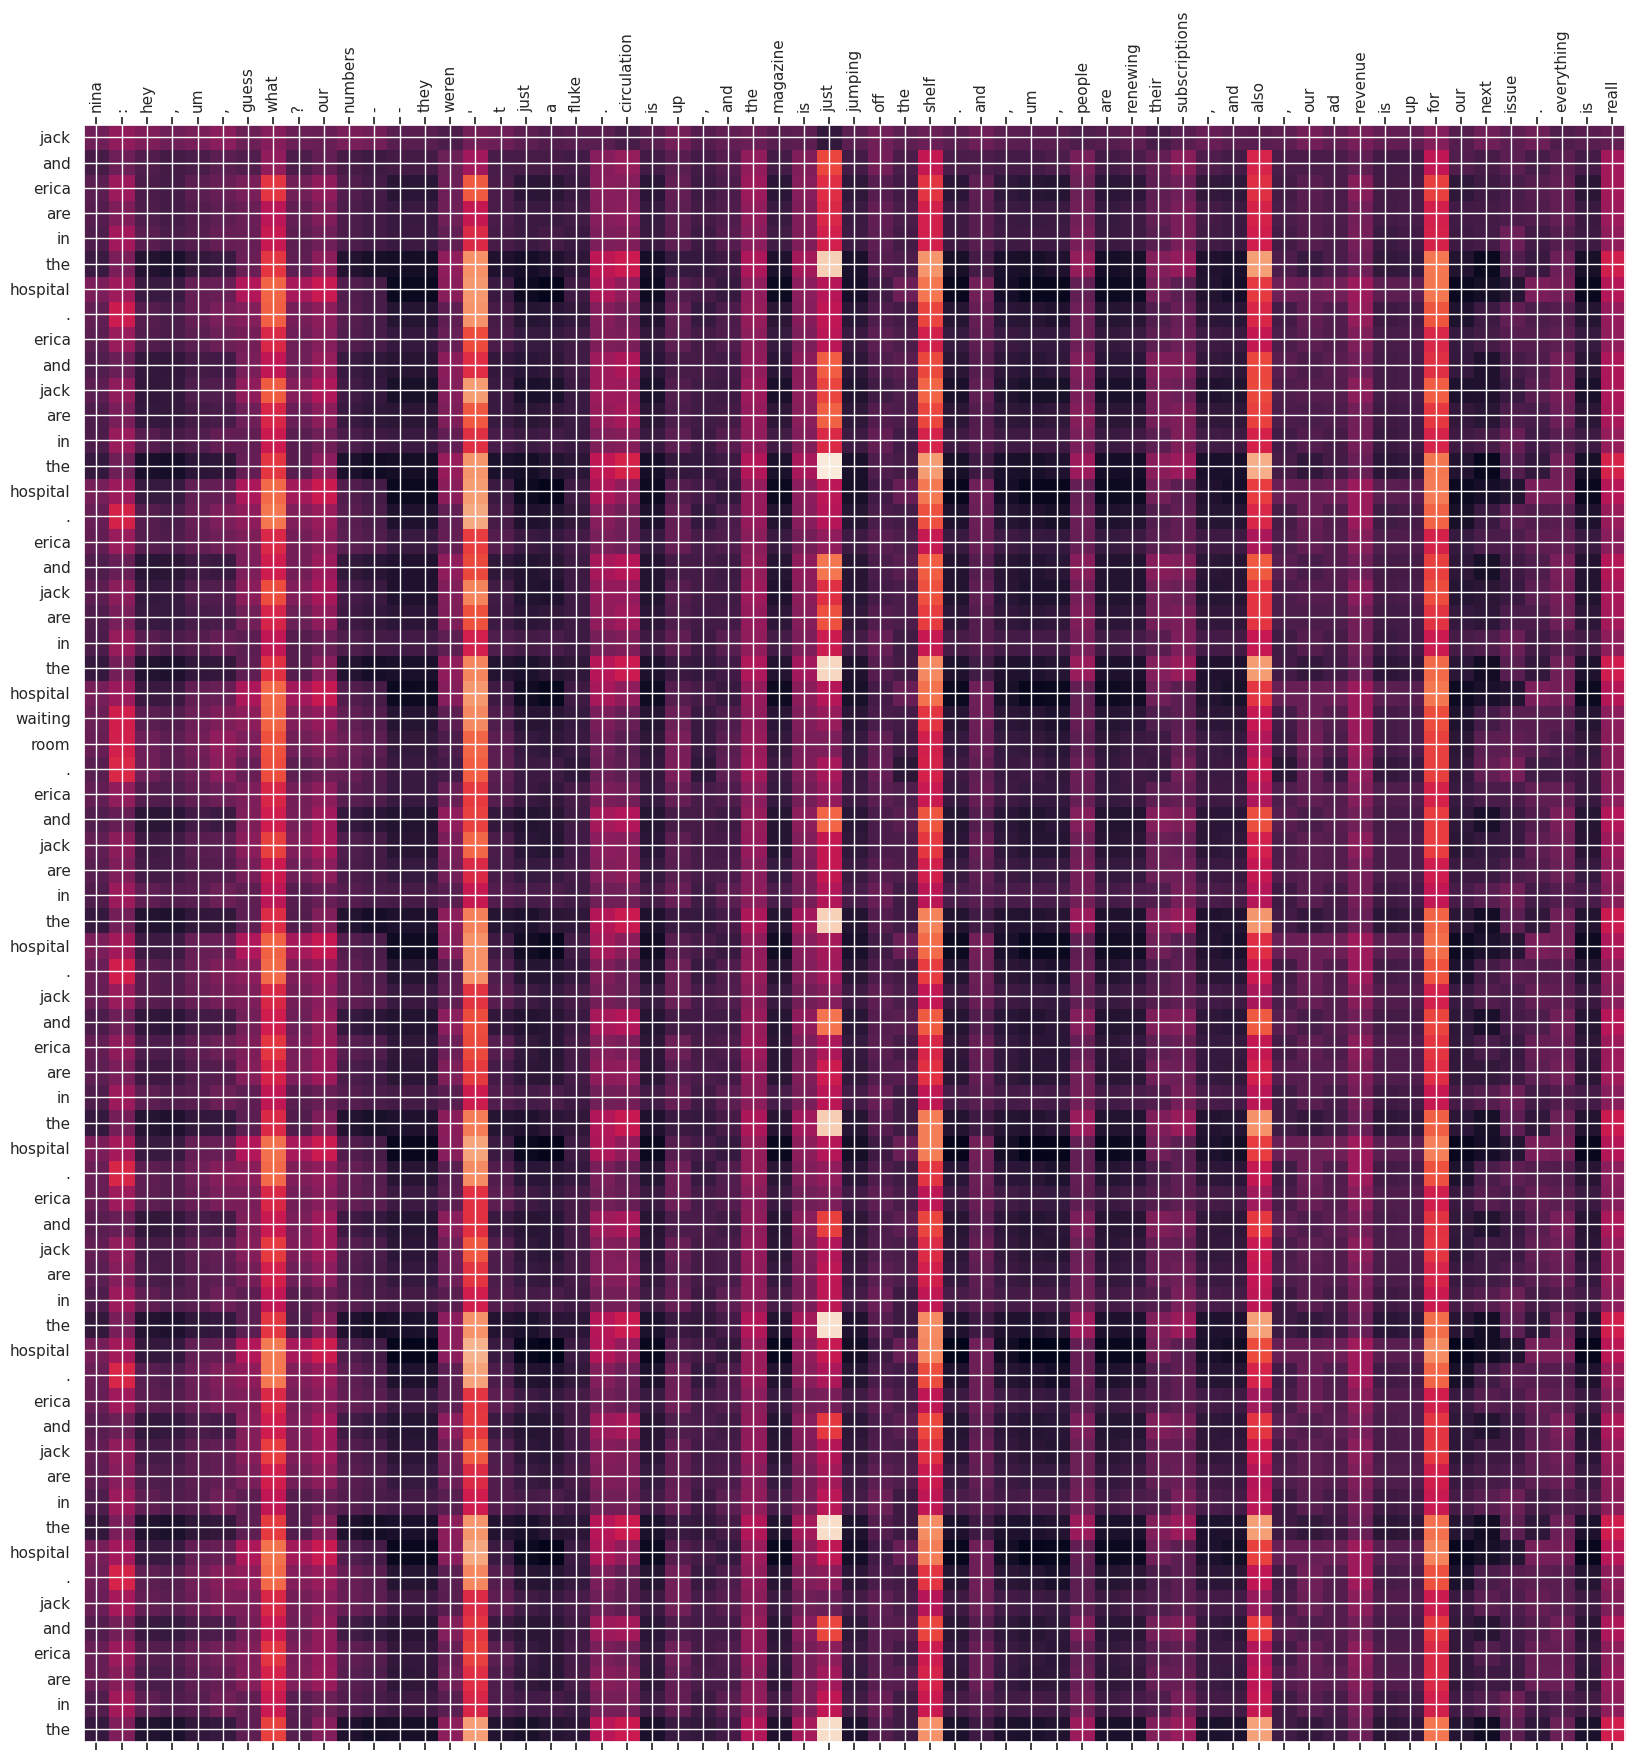

       ROUGE1_precision  ROUGE1_recall  ROUGE1_fmeasure  ROUGEL_precision  \
count         20.000000      20.000000        20.000000         20.000000   
mean           0.450628       0.138841         0.199198          0.296453   
std            0.184318       0.054998         0.066727          0.125714   
min            0.117647       0.057870         0.085106          0.078431   
25%            0.329167       0.083293         0.141949          0.198895   
50%            0.464364       0.151042         0.217483          0.312937   
75%            0.573276       0.179575         0.255620          0.353675   
max            0.864407       0.231707         0.310030          0.542373   

       ROUGEL_recall  ROUGEL_fmeasure  
count      20.000000        20.000000  
mean        0.088214         0.127829  
std         0.031146         0.039844  
min         0.044444         0.056738  
25%         0.060171         0.098858  
50%         0.087037         0.117714  
75%         0.115567      

In [ ]:
head = 1


#df_test = tfds.as_dataframe(ds_test.shuffle(1000000).take(20000), ds_info=dataset_info.DatasetInfo())

def dataset_to_dataframe(ds):
  transcript_list = []
  recap_list = []
  for transcript, recap in ds.shuffle(1000000).take(20):
    transcript_list.append(transcript.numpy())
    recap_list.append(recap.numpy())
  return pd.DataFrame({'transcript': transcript_list, 'recap': recap_list})

df_test = dataset_to_dataframe(ds_test)

plot_attention_weights = True
results  = []
for i in range(len(df_test)):
  print("Example %d of %d: " %(i + 1, len(df_test)))
  recap = df_test.iloc[i]['recap'].decode("utf-8")
  transcript = df_test.iloc[i]['transcript'][:MAX_TOKENS_TRANSCRIPT].decode("utf-8").replace('\n', ' ')
  summarized_text, summary_tokens, attention_weights = summarizer(  tf.constant(transcript))
  print_summary(transcript, summarized_text, recap)
  score = scorer.score(target = recap, prediction = summarized_text)
  result = {'ROUGE1_precision': score['rouge1'].precision,
                  'ROUGE1_recall': score['rouge1'].recall,
                  'ROUGE1_fmeasure': score['rouge1'].fmeasure,
                  'ROUGEL_precision': score['rougeL'].precision,
                  'ROUGEL_recall': score['rougeL'].recall,
                  'ROUGEL_fmeasure': score['rougeL'].fmeasure,
                  'ground_truth': recap,
                  'prediction': summarized_text,
                  'input': transcript
             }
  # Plot out the ROUGE scores
  for key, value in result.items():
    if key.startswith('ROUGE'):
      print("%12s: %3.2f" %(key, value))

  results.append(result)

  if plot_attention_weights:
    in_tokens = transcript_to_tokens(transcript)
    attention = get_attention_head(attention_weights, 1)
    plot_attention_head(in_tokens, summary_tokens, attention )



test_results = pd.DataFrame(results)
print(test_results.describe())